In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import random
kb = 1.380649e-23 
Na = 6.022e23
kc = 138.935456

In [2]:
def vel_dist(vel, temp, mass):
    mass = (mass/1000)/Na
    beta = 1/(kb*temp)
    term2 = (mass/(2 * np.pi * kb * temp))**(1/2)
    term3 = np.exp(-(beta * mass * vel**2)/2)
    prob = term2 * term3
    
    return prob

In [3]:
def sample_normal(mass, temp):
    mass = (mass / 1000)/Na
    beta = 1/(kb * temp)
    SD = 3*((1/(2 * np.pi * beta * mass))**0.5)
    vpoint = SD * np.random.randn() 
    vpoint = vpoint*0.001
    return vpoint #nm/ps

In [108]:
def anderson(mass, temp): #position in nm, mass in g/mol, temp in K
    vel_anderson = np.array([])
    for i in range(np.size(mass)):
        for j in range(3):
            norm_vel = sample_normal(mass[i], temp)
            vel_anderson = np.append(vel_anderson, norm_vel)
    vel_anderson = np.reshape(vel_anderson, (np.size(mass), 3))
    return vel_anderson

In [145]:
def kin(mass, vel):
    ke = 0.5 * mass * np.sum(vel**2)
    return ke

5a

In [178]:
#5a
def pot(r1, r2, sig1, eps1, q1, sig2, eps2, q2):
    sig = 0.5 * (sig1 + sig2)
    eps = (eps1 * eps2)**0.5
    Rij = np.sum((r1-r2)**2)**0.5 #distance in nm
    Up = 4*eps*(((sig/Rij)**12)-((sig/Rij)**6)) #kJ/mol
    Ue = (kc * q1 * q2)/ Rij
    Utot = Up + Ue
    return Utot

In [7]:
def checkerboard(shape):
    return np.indices(shape).sum(axis=0) % 2
board = checkerboard((4,4,4))

def make_cube(n, spacing = 0.282, atoms = [11, 17]):
    positions = np.zeros((n ** 3, 3))
    atom_array = np.zeros(((n ** 3), 5))
    row = 0
    for i in range(n):
        for j in range(n):
            for k in range(n):
                positions[row] = i * spacing, j * spacing, k * spacing
                if board[i, j, k] % 2 == 0:
                    #atom identity, charge, sigma, eps, mass
                    atom_array[row] = atoms[0], 1, 0.332840, 0.011590, 22.98977
                else:
                    atom_array[row] = atoms[1], -1, 0.440104, 0.418400, 35.453
                row += 1
    return positions, atom_array

In [80]:
def calcforce(p1,p2,sig1,eps1,sig2,eps2):
    sig = 0.5 * (sig1 + sig2)
    eps = (eps1 * eps2)**0.5
    
    Rij = np.sum((p1-p2)**2)**0.5
    F = (((4*eps*(((-12*sig**12)/(Rij**13))+((6*sig**6)/(Rij**7))))) * ((p1 - p2)/Rij)) * (-1)
    return F #kJ/(mol*nm) (inputing nm)

In [81]:
#5a
def calceforce(p1,p2,q1,q2):
    Rij = np.sum((p1-p2)**2)**0.5
    F = ((kc*q1*q2) / (Rij**2)) * ((p1 - p2)/Rij)
    return F #kJ/(mol*nm) (inputing nm)

In [82]:
def totforcematrix(poscube, constants):    
    atomforce3 = np.array([])
    totalforce = np.array([0, 0, 0])
    for i in range(0, np.shape(poscube)[0]):
        for j in range(0, np.shape(poscube)[0]):
            if i != j:
                Fi = calcforce(poscube[i], poscube[j], constants[i,2], constants[i,3], constants[j,2], constants[j,3]) + calceforce(poscube[i], poscube[j], constants[i,1], constants[j,1])
                totalforce = totalforce + Fi
                
        atomforce3 = np.append(atomforce3, totalforce)
        totalforce = np.array([0, 0, 0])
    atomforce3 = np.reshape(atomforce3, (np.shape(poscube)[0], 3))
    return atomforce3

5b

In [54]:
def totPEenergycube(poscube, constants):
    TotalE = 0
    for i in range(0, np.shape(poscube)[0]):
        for j in range(0, np.shape(poscube)[0]):
            if i != j:
                TotalE = TotalE + pot(poscube[i], poscube[j], constants[i,2], constants[i,3], constants[i,1], constants[j,2], constants[j,3], constants[j,1])
    TotalE = TotalE/2
    return TotalE

In [55]:
def totKEenergycube(constants, vel):
    TotalE = 0
    for i in range(0, np.shape(constants)[0]):
            TotalE = TotalE + kin(constants[i,4], vel[i])
    return TotalE

In [179]:
inposarray, constarray = make_cube(4, spacing = 0.282, atoms = [11, 17])
totPEin = totPEenergycube(inposarray, constarray)

print(totPEin) #kJ/mol

-23961.69014300989


5c

In [92]:
#opt function
def optcube(cube, size, steps, constants):
    #step_energy = np.array([])
    for i in range(0, steps):
        forcematrix = totforcematrix(cube, constants)
        #energystep = totPEenergycube(cube, constants)
        #step_energy = np.append(step_energy, energystep)
        normalize = np.linalg.norm(forcematrix)
        stepsize = (forcematrix / normalize) * size
        cube = cube + stepsize
    return cube #, step_energy

In [95]:
in_opt_pos = optcube(inposarray, 0.001, 1000, constarray)

PEin = totPEenergycube(in_opt_pos, constarray)

print(PEin)

#print(totforcematrix(inposarray, constarray))

-24023.963165089433


In [146]:
#initial vel
mass = constarray[:,4]
#print(np.size(mass))
in_vel = anderson(mass, 1200)


In [147]:
#vel-verlet function
def MDcalc(positions, constants, velocities, dt, steps): #nm, g/mol, nm/ps, ps, steps
    r_curr = positions.copy()
    v_curr = velocities.copy()
    mass = np.array([constants[:, 4]])
    mass = np.reshape(mass, (64,1))
    r_traj = np.array([])
    v_traj = np.array([])
    pe_traj = np.array([])
    ke_traj = np.array([])
    for step in range(steps):
        r_traj = np.append(r_traj, r_curr)
        v_traj = np.append(v_traj, v_curr)
        if step == 0:
            potential = totPEenergycube(r_curr, constants)
            f_curr = totforcematrix(r_curr, constants)
        kinetic = totKEenergycube(constants, v_curr)
        pe_traj = np.append(pe_traj, potential)
        ke_traj = np.append(ke_traj, kinetic)
        a_curr = f_curr / mass
        r_next = r_curr + (v_curr * dt) + (0.5 * a_curr * (dt**2))
        pot_next = totPEenergycube(r_next, constants)
        f_next = totforcematrix(r_next, constants)
        a_next = f_next / mass
        v_next = v_curr + 0.5*(a_curr + a_next)*dt
        f_curr = f_next.copy()
        potential = pot_next
        r_curr = r_next.copy()
        v_curr = v_next.copy()
  
    return r_traj, v_traj, pe_traj, ke_traj

In [157]:
# 0.005ps 2000 steps

r_traj_5c, v_traj_5c, pe_traj_5c, ke_traj_5c = MDcalc(in_opt_pos, constarray, in_vel, 0.005, 2000)

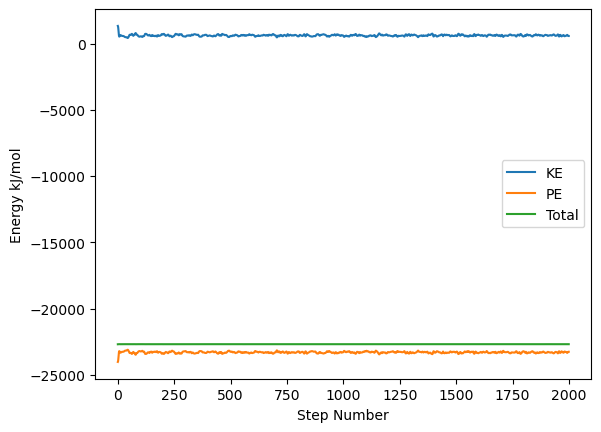

In [158]:
#ke and pe graph
n_steps = range(0,2000)

total_traj_5c = ke_traj_5c + pe_traj_5c

fig, ax = plt.subplots()
ax.plot(n_steps, ke_traj_5c, label = 'KE')
ax.plot(n_steps, pe_traj_5c, label = 'PE')
ax.plot(n_steps, total_traj_5c, label = 'Total')
ax.set_xlabel('Step Number')
ax.set_ylabel('Energy kJ/mol')
ax.legend()

plt.show()

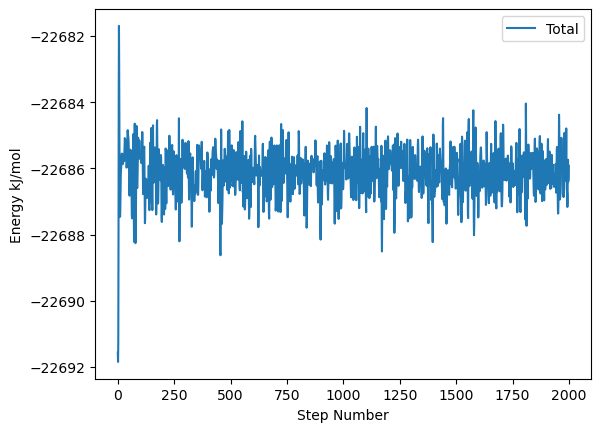

In [159]:
ig, ax = plt.subplots()

ax.plot(n_steps, total_traj_5c, label = 'Total')
ax.set_xlabel('Step Number')
ax.set_ylabel('Energy kJ/mol')
ax.legend()

plt.show()

5d

In [180]:
def constT_MDcalc(positions, constants, dt, steps, temp): #nm, g/mol, nm/ps, ps, steps, K
    r_curr = positions.copy()
    mass = np.array([constants[:, 4]])
    mass = np.reshape(mass, (64,1))
    r_traj = np.array([])
    v_traj = np.array([])
    pe_traj = np.array([])
    ke_traj = np.array([])
    rg_traj = np.array([])
    for step in range(steps):
        r_traj = np.append(r_traj, r_curr)
        if step%200 == 0:
            v_curr = anderson(mass, temp)
            rg = np.sqrt((1 / 64) * np.sum((r_curr - np.mean(r_curr))**2))
            rg_traj = np.append(rg_traj, rg)
        if step == 0:
            potential = totPEenergycube(r_curr, constants)
            f_curr = totforcematrix(r_curr, constants)
        kinetic = totKEenergycube(constants, v_curr)
        pe_traj = np.append(pe_traj, potential)
        ke_traj = np.append(ke_traj, kinetic)
        a_curr = f_curr / mass
        r_next = r_curr + (v_curr * dt) + (0.5 * a_curr * (dt**2))
        pot_next = totPEenergycube(r_next, constants)
        f_next = totforcematrix(r_next, constants)
        a_next = f_next / mass
        v_next = v_curr + 0.5*(a_curr + a_next)*dt
        f_curr = f_next.copy()
        potential = pot_next
        r_curr = r_next.copy()
        v_curr = v_next.copy()
  
    return r_traj, v_traj, pe_traj, ke_traj, rg_traj

In [197]:
r_traj_5d, v_traj_5d, pe_traj_5d, ke_traj_5d, rg_traj_5d = constT_MDcalc(in_opt_pos, constarray, 0.005, 100000, 1200)

KeyboardInterrupt: 

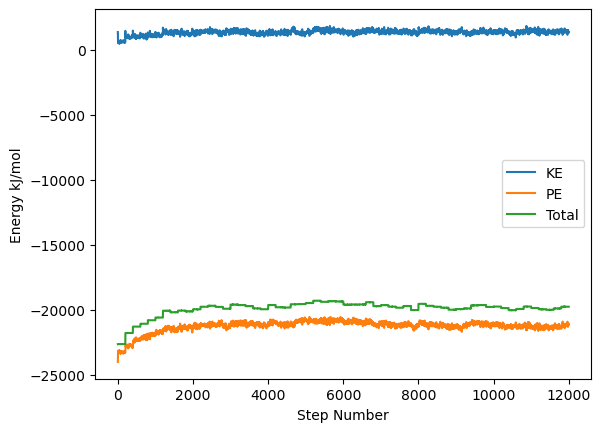

In [195]:
#ke and pe graph
n_steps = range(0,100000)

total_traj_5d = ke_traj_5d + pe_traj_5d

fig, ax = plt.subplots()
ax.plot(n_steps, ke_traj_5d, label = 'KE')
ax.plot(n_steps, pe_traj_5d, label = 'PE')
ax.plot(n_steps, total_traj_5d, label = 'Total')
ax.set_xlabel('Step Number')
ax.set_ylabel('Energy kJ/mol')
ax.legend()

plt.show()

5e

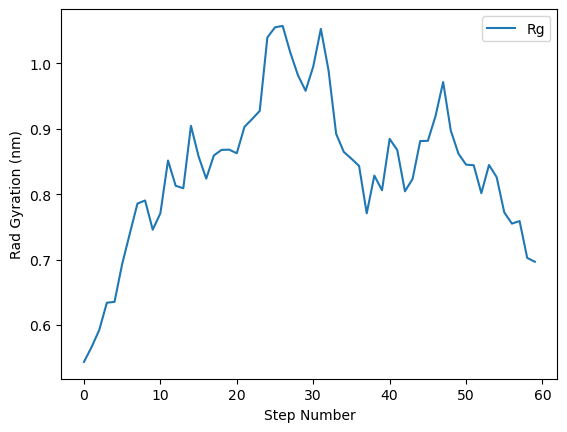

In [196]:

fig, ax = plt.subplots()
ax.plot(range(200), rg_traj_5d, label = 'Rg')
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Rad Gyration (nm)')
ax.legend()

plt.show()

In [ ]:
trunc_traj_5d = rg_traj_5d[0, 100:200]
mean_5d = np.mean(trunc_traj_5d)
sd_5d = np.std(trunc_traj_5d)

print(mean_5d)
print(sd_5d)

5f

In [ ]:

r_traj_5f, v_traj_5f, pe_traj_5f, ke_traj_5f, rg_traj_5f = constT_MDcalc(in_opt_pos, constarray, 0.005, 100000, 1400)

In [ ]:
trunc_traj_5f = rg_traj_5f[0, 100:200]
mean_5f = np.mean(trunc_traj_5f)
sd_5f = np.std(trunc_traj_5f)

print(mean_5f)
print(sd_5f)

a = (1 / (mean_5d)) * ((mean_5d - mean_5f)/(1400 - 1200))
print(a)

5g

In [ ]:
r_traj_5g, v_traj_5g, pe_traj_5g, ke_traj_5g, rg_traj_5g = constT_MDcalc(in_opt_pos, constarray, 0.005, 100000, 1300)

In [ ]:
trunc_traj_5g = rg_traj_5g[0, 100:200]
mean_5g = np.mean(trunc_traj_5g)
sd_5g = np.std(trunc_traj_5g)

print(mean_5g)
print(sd_5g)

alph = (1 / (mean_5g)) * (sd_5g**2)
print(alph)